# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples=5):
### STUDENT START ###
    for x in range(0,num_examples):
        print "Training Example %d" %(x)
        print "Category #%d: %s" %(train_labels[x], newsgroups_train.target_names[train_labels[x]])
        print "Text:"
        print train_data[x]
        print "------------------------------------------------------------------------------"
        print 
### STUDENT END ###
P1(5)

Training Example 0
Category #1: comp.graphics
Text:
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
------------------------------------------------------------------------------

Training Example 1
Category #3: talk.religion.misc
Text:


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delus

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [4]:
def P2():
### STUDENT START ###
    print "Part a:"
    news = CountVectorizer()
    ft_csr_matrix = news.fit_transform(train_data)
    print "The size of the vocabulary is %d words." %ft_csr_matrix.shape[1]
    print "The average number of non-zero features is %.2f words." % (ft_csr_matrix.nnz / float(ft_csr_matrix.shape[0]))
    print "The fraction of non-zero entries in the matrix are %.8f." % (ft_csr_matrix.nnz / (float(ft_csr_matrix.shape[0] * ft_csr_matrix.shape[1])))
    
    print; print "Part b:"
    feat_name_list = news.get_feature_names()
    print "The 0th feature string (in alphabetical order) is '%s'" %feat_name_list[0]
    print "The last feature string (in alphabetical order) is '%s'" %feat_name_list[-1]

    print; print "Part c:"
    my_vocab = ["atheism", "graphics", "space", "religion"]
    news2 = CountVectorizer(vocabulary = my_vocab)
    ft2_csr_matrix = news2.fit_transform(train_data)
    print "The shape of the csr matrix is: %s" % (ft2_csr_matrix.shape,)
    print "The average number of non-zero features is %.2f words." % (ft2_csr_matrix.nnz / float(ft2_csr_matrix.shape[0]))

    print; print "Part d:"
    news3 = CountVectorizer(analyzer='char', ngram_range=(2,3))
    ft3_csr_matrix = news3.fit_transform(train_data)
    print "The size of the combined bigram/trigram character vocabulary is %d words." %ft3_csr_matrix.shape[1]
    
    print; print "Part e:"
    news4 = CountVectorizer(min_df=10)
    ft4_csr_matrix = news4.fit_transform(train_data)
    print "The size of the pruned vocabulary is %d words." %ft4_csr_matrix.shape[1]

    print; print "Part f:"
    train_csr_matrix = news.fit_transform(train_data)
    train_names = news.get_feature_names()
    dev_csr_matrix = news.fit_transform(dev_data)
    dev_names = news.get_feature_names()
    print "The size of the train vocabulary is %d words." %train_csr_matrix.shape[1]
    print "The size of the dev vocabulary is %d words." %dev_csr_matrix.shape[1]
    dev_not_train_size = len(set(dev_names) - set(train_names))
    print "There are %d words in the dev set and not in the train set." %dev_not_train_size
    print "%.3f%% of the words in the dev set are not in the train set." % (dev_not_train_size / float(len(dev_names)))

### STUDENT END ###
P2()

Part a:
The size of the vocabulary is 26879 words.
The average number of non-zero features is 96.71 words.
The fraction of non-zero entries in the matrix are 0.00359783.

Part b:
The 0th feature string (in alphabetical order) is '00'
The last feature string (in alphabetical order) is 'zyxel'

Part c:
The shape of the csr matrix is: (2034, 4)
The average number of non-zero features is 0.27 words.

Part d:
The size of the combined bigram/trigram character vocabulary is 35478 words.

Part e:
The size of the pruned vocabulary is 3064 words.

Part f:
The size of the train vocabulary is 26879 words.
The size of the dev vocabulary is 16246 words.
There are 4027 words in the dev set and not in the train set.
0.248% of the words in the dev set are not in the train set.


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [5]:
def P3():
### STUDENT START ###
    print "Part 1 - KNN:"
    news = CountVectorizer()
    train_csr_data = news.fit_transform(train_data)
    dev_csr_data = news.transform(dev_data)
    
    # Let's use NBGridSearch to find the best values. Note this does not use dev data, so gives a slightly
    # different answers than manually testing various params on the dev.
    print; print "Part 1 - KNN:"
    ks = {'n_neighbors': range(1,2)}
    KNNGridSearch = GridSearchCV(KNeighborsClassifier(), ks, scoring='f1_weighted')
    KNNGridSearch.fit(train_csr_data, train_labels)
    # Report out on the accuracies    
    print "The best k value was %s with accuracy %.4f" % (KNNGridSearch.best_params_, KNNGridSearch.best_score_)
    
    print; print "Part 2 - MNB:"
    alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
    NBGridSearch = GridSearchCV(MultinomialNB(), alphas, scoring='f1_weighted')
    NBGridSearch.fit(train_csr_data, train_labels)
    print "The best alpha value was %s with accuracy %.4f" % (NBGridSearch.best_params_, NBGridSearch.best_score_)

    print; print "Part 3 - Logistic Regression:"
    Cs = {'C': np.arange(0.25, 5, 0.25)}
    LRGridSearch = GridSearchCV(LogisticRegression(penalty='l2'), Cs, scoring='f1_weighted')
    LRGridSearch.fit(train_csr_data, train_labels)
    print "The best C value was %s with accuracy %.4f" % (LRGridSearch.best_params_, LRGridSearch.best_score_)
    
    # Because we need to post-process the coeffs, we need to not just use GridSearchCV
    print
    for c in Cs['C']:
        LRModel = LogisticRegression(C=c, penalty='l2')
        LRModel.fit(train_csr_data, train_labels)
        dev_predict = LRModel.predict(dev_csr_data)
        print "C = %f, Accuracy = %f" % (c, metrics.f1_score(dev_labels, dev_predict, average='weighted'))
        # print the sum of squares per classification
        print np.sum(LRModel.coef_**2, axis=1)

### STUDENT END ###
P3()

Part 1 - KNN:

Part 1 - KNN:
The best k value was {'n_neighbors': 1} with accuracy 0.4048

Part 2 - MNB:
The best alpha value was {'alpha': 0.01} with accuracy 0.8287

Part 3 - Logistic Regression:
The best C value was {'C': 0.25} with accuracy 0.7679

C = 0.250000, Accuracy = 0.708058
[ 59.82999069  50.60312336  58.95649655  51.47657774]
C = 0.500000, Accuracy = 0.708474
[ 102.59743971   83.09094079   99.0172645    89.00720041]
C = 0.750000, Accuracy = 0.692585
[ 137.31730811  108.95986004  130.96557369  119.51273623]
C = 1.000000, Accuracy = 0.696086
[ 166.97064303  130.88335686  158.00270089  145.71513838]
C = 1.250000, Accuracy = 0.694841
[ 193.12069306  150.20957072  181.64596833  168.93266854]
C = 1.500000, Accuracy = 0.689000
[ 216.60968439  167.5702937   202.73379848  189.79939918]
C = 1.750000, Accuracy = 0.692368
[ 237.93790005  183.3777182   221.99819445  208.94296515]
C = 2.000000, Accuracy = 0.692483
[ 257.35317511  197.91064391  239.70319021  226.59465869]
C = 2.250000, A

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/naive_bayes.py:607: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc)


ANSWER:
a) The nearest neighbors does not work well because we have a very sparse vector space with many features (words) that differ between training examples. As such, the nearest neighbor might be quite a ways off! Because of this distance, it makes sense that our classifer makes a lot of mistakes.

b) The NB model assumes independance between features. That is, for each potential classification, we calculate the likelihood of that classification given each indpendant feature we see. There is no linearity requirement. However, Logistic Regression attempts to draw a line to separate the data points. Since the feature space of words is large and complicated, it makes sense that NB preforms better.

c) L2 regularization penalizes large coefficients, because large coefficients are more likely to occur when we are overfitting. As we see above, low value of C (stronger regularization) leads to lower model coefficients beacuse of higher regularization penalites. In this case, we see that models with higher penalities wind up with lower coefficients, expressed as the sum of squared coefficients.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [5]:
def P4():
### STUDENT START ###

    # This function fits the regression model then plots a table with the desired solutions
    def model_and_table():
        # Let's store the feature names for faster lookup later
        feature_names = np.array(news.get_feature_names())
        
        # Next, fit an LR Model using the C we calculated above
        LRModel = LogisticRegression(C=0.25, penalty='l2')
        LRModel.fit(train_csr_data, train_labels)

        # Use argpartition to get the top indexes - we don't need a sort, just the max 5 per classification
        top_index = np.argpartition (LRModel.coef_, kth=-5, axis=1)[:,-5:].flatten()
        top_features = feature_names[top_index]

        # Create a table to store results    
        results_table = np.zeros((20,len(newsgroups_train.target_names)))
        for i in range(0,len(newsgroups_train.target_names)):
            weights = LRModel.coef_[i,top_index]
            results_table[:,i] = weights

        # Print table with row names for ease of reading
        # We use ljust for padding so the rows line up
        print newsgroups_train.target_names
        for x in range(0,results_table.shape[0]):
            print top_features[x].ljust(len(max(top_features, key=len))), results_table[x]
    
    # Let's start with the unigram features
    # First, use count vectorizer to create a sparse matrix of word features
    news = CountVectorizer()
    train_csr_data = news.fit_transform(train_data)
    print "LR with unigram features:"
    model_and_table()
    
    # Now, the bigram features
    news = CountVectorizer(ngram_range=(2,3))
    train_csr_data = news.fit_transform(train_data)
    print; print "LR with bigram features:"
    model_and_table()
    
### STUDENT END ###
P4()

LR with unigram features:
['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
islam      [ 0.56266036 -0.09648974 -0.22982357 -0.23221406]
bobby      [ 0.66739039 -0.16094036 -0.23303012 -0.31523309]
atheism    [ 0.6577224  -0.28812388 -0.2898333  -0.32734893]
atheists   [ 0.65835261 -0.08892118 -0.21756365 -0.4682063 ]
religion   [ 0.65746704 -0.41063942 -0.53697651 -0.02781081]
computer   [ 0.01100994  0.71896742 -0.46062697 -0.31695911]
file       [-0.22733361  0.86683596 -0.56513246 -0.40274068]
3d         [-0.24898779  0.76536132 -0.45059903 -0.25691279]
image      [-0.37067568  0.90048806 -0.530398   -0.30304741]
graphics   [-0.53493114  1.34144304 -0.89201682 -0.50644742]
spacecraft [-0.24122868 -0.25814833  0.57273899 -0.21711024]
launch     [-0.29745988 -0.32949679  0.64353721 -0.23021325]
nasa       [-0.37283896 -0.34350282  0.70736073 -0.33611065]
orbit      [-0.29008459 -0.45611276  0.8200068  -0.38004857]
space      [-0.87571739 -0.93090531  1.58946895 -0.7

ANSWER: The unigram output is fairly predictable. The results are mostly single-word nouns. Some surprising results: "Bobby" with alt.atheism (perhaps an individual named bobby posts frequently), and "fbi" with talk.religion.misc.

The bigram output surprised me. While we have some noun-verb phrases, we also have many prepositions and other "stop word" combinations. "In this", "is not", "it was" are not phrases I would expect to help the model predict outcomes. However, perhaps the nature of discussion makes this make snese. For example, "looking for" makes sense in the space context. "Is not" makes sense in the context of atheism. I doubt I would have thought of looking for these phrases without machine learning methods.

It makes me happy that "the moon" is one of the top bigrams for space. The moon is awesome.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [9]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###
    # Note: Spent roughly 40 minutes trying different things. These seemed to work.
    s = s.lower()
    s = re.sub(r'\b[0-9]+[.,]*[0-9]+\b', 'NUMBER_STRING', s)
    s = re.sub(r'[><_]', '',s)
    
    # We can't import NLTK to stem. But let's hack things away
    s = re.sub(r's\b', '', s)
    # Finding: Removing other endings seems to hurt accuracy too much

    return s

### STUDENT END ###

def P5():
### STUDENT START ###
    def run_model(news):
        # Vectorize words
        train_csr_data = news.fit_transform(train_data)
        dev_csr_data = news.transform(dev_data)
        print "The size of the vocabulary is %d words" %(train_csr_data.shape[1])
        
        # Build model and print accuracy
        LRModel = LogisticRegression(C=0.25, penalty='l2')
        LRModel.fit(train_csr_data, train_labels)
        dev_predict = LRModel.predict(dev_csr_data)
        print "Accuracy = %f" % (metrics.f1_score(dev_labels, dev_predict, average='weighted'))

    print "Part 1 - No preprocessing:"
    news = CountVectorizer(preprocessor=empty_preprocessor)
    run_model(news)

    print; print "Part 2 - With preprocessing:"
    news = CountVectorizer(preprocessor=better_preprocessor)
    run_model(news)

    print; print "We managed to increase accuracy by %.2f while decreasing vocabulary by %d" % (0.722882-0.704429, 33291 -22245 )

### STUDENT END ###
P5()

Part 1 - No preprocessing:
The size of the vocabulary is 33291 words
Accuracy = 0.704429

Part 2 - With preprocessing:
The size of the vocabulary is 22245 words
Accuracy = 0.722882

We managed to increase accuracy by 0.02 while decreasing vocabulary by 11046


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

The size of the vocabulary is 26879 words
Starting L2 Accuracy = 0.704376
Starting L1 Accuracy = 0.694549

There are 26879 distinct features in the data.
L1 model has 747 nonzero weights for 427 distinct features.
L2 model has 107516 nonzero weights for 26879 distinct features.
L2 Accuracy on nonzero L1 features = 0.677653

Starting Loop:


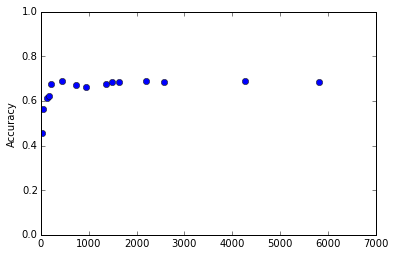

In [10]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    # Vectorize words
    news = CountVectorizer()
    train_csr_data = news.fit_transform(train_data)
    dev_csr_data = news.transform(dev_data)
    print "The size of the vocabulary is %d words" %(train_csr_data.shape[1])

    # Train with L2 penalty as basis for comparison. Use tol=0.01 consistantly in this problem
    L2Model = LogisticRegression(C=0.25, penalty='l2', tol=.01)
    L2Model.fit(train_csr_data, train_labels)
    L2dev_predict = L2Model.predict(dev_csr_data)
    print "Starting L2 Accuracy = %f" % (metrics.f1_score(dev_labels, L2dev_predict, average='weighted'))
    
    # Train with l1 penalty. Use tol=0.01 consistantly in this problem
    L1Model = LogisticRegression(C=0.25, penalty='l1', tol=.01)
    L1Model.fit(train_csr_data, train_labels)
    L1dev_predict = L1Model.predict(dev_csr_data)
    print "Starting L1 Accuracy = %f" % (metrics.f1_score(dev_labels, L1dev_predict, average='weighted'))

    # Get number of learned L1 weights not = 0
    print; print "There are %d distinct features in the data." % train_csr_data.shape[1]
    print "L1 model has %d nonzero weights for %d distinct features." % (np.count_nonzero(L1Model.coef_),np.count_nonzero(np.sum(L1Model.coef_, axis=0))) 
    # Compare to non-zero weights with L2
    print "L2 model has %d nonzero weights for %d distinct features." % (np.count_nonzero(L2Model.coef_),np.count_nonzero(np.sum(L2Model.coef_, axis=0)))
    
    # Keep only features with at least one non-zero L1 weight
    nonzero_index = np.nonzero(np.sum(L1Model.coef_, axis=0))
    #print nonzero
    train_csr_data_alt = train_csr_data[:,nonzero_index[0]]
    dev_csr_data_alt = dev_csr_data[:,nonzero_index[0]]    
    
    # Retrain L2 with only these features
    AltL2Model = LogisticRegression(C=0.25, penalty='l2', tol=.01)
    AltL2Model.fit(train_csr_data_alt, train_labels)
    AltL2dev_predict = AltL2Model.predict(dev_csr_data_alt)
    print "L2 Accuracy on nonzero L1 features = %f" % (metrics.f1_score(dev_labels, AltL2dev_predict, average='weighted'))

    # Iterate through Cs, saving accuracy and vocab size
    C_list = [0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0, 25.0, 50.0]
    accuracy_list = []
    feature_size_list = []
    print; print "Starting Loop:"
    for this_C in C_list:
        L1Model = LogisticRegression(C=this_C, penalty='l1', tol=.01)
        L1Model.fit(train_csr_data, train_labels)
        L1dev_predict = L1Model.predict(dev_csr_data)

        # Get number of features where L1 weights not = 0
        feature_size_list.append(np.count_nonzero(np.sum(L1Model.coef_, axis=0))) 

        # Keep only features with at least one non-zero L1 weight
        nonzero_index = np.nonzero(np.sum(L1Model.coef_, axis=0))
        train_csr_data_alt = train_csr_data[:,nonzero_index[0]]
        dev_csr_data_alt = dev_csr_data[:,nonzero_index[0]]    

        # Retrain L2 with only these features
        AltL2Model = LogisticRegression(C=this_C, penalty='l2', tol=.01)
        AltL2Model.fit(train_csr_data_alt, train_labels)
        AltL2dev_predict = AltL2Model.predict(dev_csr_data_alt)
        accuracy_list.append(metrics.f1_score(dev_labels, AltL2dev_predict, average='weighted'))
        
    # Plot accuracy vs. vocab size.
    plt.plot(feature_size_list, accuracy_list, 'bo')
    plt.ylabel('Accuracy')
    plt.axis([0, 7000, 0, 1])

    
    ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [11]:
def P7():
### STUDENT START ###
    # Vectorize words w/ CountVectorizer
    news = CountVectorizer()
    train_csr_data = news.fit_transform(train_data)
    dev_csr_data = news.transform(dev_data)

    # Vectorize words w/ TfidfVectorizer
    tf_news = TfidfVectorizer()
    tf_train_csr_data = tf_news.fit_transform(train_data)
    tf_dev_csr_data = tf_news.transform(dev_data)
    
    # LR Model - Count
    LRModel = LogisticRegression(C=100, penalty='l2', tol=.01)
    LRModel.fit(train_csr_data, train_labels)
    dev_predict = LRModel.predict(dev_csr_data)
    print "CountVector Accuracy = %f" % (metrics.f1_score(dev_labels, dev_predict, average='weighted'))

    # LR Model - Tfidf
    LRModel.fit(tf_train_csr_data, train_labels)
    dev_predict = LRModel.predict(tf_dev_csr_data)
    print "Tfidf Accuracy = %f" % (metrics.f1_score(dev_labels, dev_predict, average='weighted'))
    
    # Get predicted probabilities, max probability, probability of correct label, and R
    probs = LRModel.predict_proba(tf_dev_csr_data)
    max_prob = np.max(probs, axis = 1)
    correct_prob = probs[np.arange(probs.shape[0]), dev_labels]
    R = max_prob / correct_prob
    #Hooray!!
    
    # Get index for 3 largest R values so we can look at documents.
    # Use argpartition to get the top indexes - we don't need a sort, just the max 3
    top_R = np.argpartition (R,-3)[-3:]
    # print docs
    print "-----------------------------------------"
    for this_R in top_R:
        print "Classified as: %s" % newsgroups_train.target_names[dev_predict[this_R]]
        print "Actually: %s" % newsgroups_train.target_names[dev_labels[this_R]]
        print dev_data[this_R]
        print "-----------------------------------------"
    
### STUDENT END ###
P7()

CountVector Accuracy = 0.694966
Tfidf Accuracy = 0.767458
-----------------------------------------
Classified as: comp.graphics
Actually: talk.religion.misc
Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.
-----------------------------------------
Classified as: talk.religion.misc
Actually: alt.atheism

The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...

-----------------------------------------
Classified as: comp.graphics
Actually: talk.religion.misc
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (min

ANSWER: CountVectorizor returns a matrix with counts for the number of times a word occurs in a document. TfIdf applies the tf-idf formula to return a score for each word based on the importance of the word to search results (under tf-idf).

There are two types of errors these three examples show. Two are religious discusions about Mormons that are using technical terms such as FTP. THese are being misclassified as computer graphics discussions. The thid document is more nuanced - a very short posting about a shooting, classified as "religion" when it should be "atheism".

One solution may be to try using a bigram model for TF-IDF. This might help us differentiate between technical terms used in technical context, from technical terms being used in the same post as terms such as "Book [stop word] Mormon". I imagine it is quite easy for the alg to mix up "religion" and "atheism" as the two discussion topics have some common elements. We also might want to create an ensemble method that simply tries to pick between "atheism" and "religon". When the probabilities of the current method are close, we could look to this second model for more information.

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance